In [1]:
import numpy as np
import nengo
from nengo import spa
import nengo_gui
import matplotlib.pyplot as plt
import brian.hears as bh
from tbekolay import auditory_periphery as ap
from tbekolay import filters
from tbekolay import processes
from tbekolay import utils

In [14]:
def normalize(sig):
    return sig/float(np.max(np.abs(sig)))

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


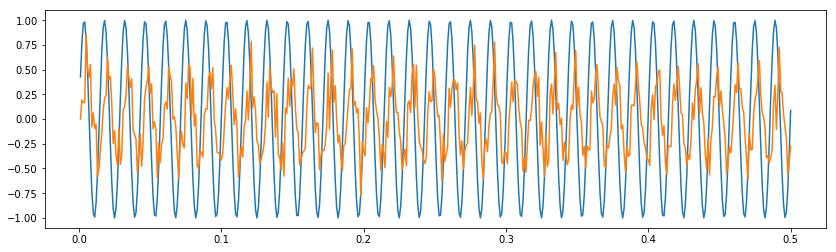

In [2]:
model = nengo.Network(label="Network")

with model:
    tone = nengo.Node(lambda t: np.sin(440*t))
    cochlea = nengo.Ensemble(n_neurons=200, dimensions=1)
    def feedback(x):
        return 1*x
    nengo.Connection(tone, cochlea)
#     nengo.Connection(cochlea, cochlea, synapse=0.05, function=feedback)
    tone_probe = nengo.Probe(tone)
    cochlea_probe = nengo.Probe(cochlea)
    
sim = nengo.Simulator(model)
sim.run(0.5)   

t = sim.trange()

plt.figure(figsize=(14,4))
plt.plot(t, sim.data[tone_probe])
plt.plot(t, sim.data[cochlea_probe])
plt.show()

In [94]:
PitchMemoryModel = nengo.Network(label="Network")

with PitchMemoryModel:
    G4_freq = 392.0
    A4_freq = 440.0
    B4_freq = 493.88
    
#     sound_process = processes.Tone(freq_in_hz = A4_freq)
#     sound_process = processes.ToneRamp(minfreq=200, maxfreq=500, t_ramp=0.1)
#     sound_process = processes.WhiteNoise()
#     sound_process = processes.ArrayProcess(np.array([processes.Tone(A4_freq), processes.Tone(B4_freq)]))

    tone = nengo.Node(sound_process)
    # cochlea = nengo.networks.AuditoryPeriphery
    cochlea = ap.AuditoryPeriphery(freqs = filters.melspace(200, 8000, 32), 
                                   sound_process = sound_process,
                                   auditory_filter = "gammatone", fs = 44100.)
    # Auditory nerve synapse
    tau_an = 0.01
    
    memory = nengo.Ensemble(3200, dimensions=32)
    nengo.Connection(cochlea.an.output, memory, synapse=tau_an)
    nengo.Connection(memory, memory, synapse=tau_an)
    

    #   --- PROBES ---   #
    tone_probe = nengo.Probe(tone)
    hair_probe = nengo.Probe(cochlea.ihc)
    cochlea_probe = nengo.Probe(cochlea.an.output)
    mem_probe = nengo.Probe(memory, synapse = tau_an)

PitchSim = nengo.Simulator(PitchMemoryModel, dt=1./44100.)
PitchSim.run(0.1)
t = PitchSim.trange()

Building finished in 0:00:08.                                                   
Simulating finished in 0:00:01.                                                 


TypeError: float() argument must be a string or a number

In [ ]:
# print t.shape
# print np.transpose(PitchSim.data[hair_probe])[0].shape
# print np.transpose(PitchSim.data[cochlea_probe])[0].shape
# print filters.melspace(200, 8000, 32)

plt.figure(figsize=(16,5))
plt.plot(t, PitchSim.data[tone_probe], label="tone")
# for p, l in zip(np.transpose(PitchSim.data[hair_probe]), filters.melspace(200, 8000, 32)):
#     plt.plot(t, p, label=str(round(l*10)/10) + "hz")
# plt.plot(t, np.transpose(PitchSim.data[hair_probe])[i], label="hair cells")
# plt.plot(t, normalize(np.transpose(PitchSim.data[cochlea_probe])[i]), label="auditory nerve (norm)")
plt.plot(t, PitchSim.data[mem_probe])

plt.legend(loc="best")
# plt.xlim(0.02, 0.12)
plt.show()